# MLP Terminology Tagger

In [1]:
import os
import random
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
import copy
from tqdm import tqdm
from preprocessing import TermsDataset

In [2]:
directory = 'terminology-project-2022/' # Path to the annotated terminology project data
#vocab_path = '/Users/josephkeenan/Desktop/'

#split = 'train' # train, test, or dev
train_data = TermsDataset(directory, 'train', one_hot=True)
test_data = TermsDataset(directory, 'test', one_hot=True)
dev_data = TermsDataset(directory, 'dev', one_hot=True)

In [3]:
train_split = list(zip(*train_data))
test_split = list(zip(*test_data))
dev_split = list(zip(*dev_data))

In [4]:
train_i = train_split[0]
train_labels = train_split[1]
train_labels = [int(label) for label in train_labels]

test_i = test_split[0]
test_labels = test_split[1]
test_labels = [int(label) for label in test_labels]

dev_i = dev_split[0]
dev_labels = dev_split[1]
dev_labels = [int(label) for label in dev_labels]

In [5]:
train_labels_unique, train_count = np.unique(train_labels, return_counts=True)
test_labels_unique, test_count = np.unique(test_labels, return_counts=True)
dev_labels_unique, dev_count = np.unique(dev_labels, return_counts=True)

In [6]:
print(train_count)
print(test_count)
print(dev_count)

[ 2615  2860 16017]
[ 328  388 2056]
[ 285  290 1832]


In [7]:
train_class_weights = [sum(train_count)/c for c in train_count]
print(train_class_weights)

test_class_weights = [sum(test_count)/c for c in test_count]
print(test_class_weights)

dev_class_weights = [sum(dev_count)/c for c in dev_count]
print(dev_class_weights)

[8.218738049713194, 7.514685314685314, 1.3418243116688517]
[8.451219512195122, 7.144329896907217, 1.3482490272373542]
[8.445614035087718, 8.3, 1.3138646288209608]


In [8]:
train_weights = [train_class_weights[e] for e in train_labels]
test_weights = [test_class_weights[e] for e in test_labels]
dev_weights = [dev_class_weights[e] for e in dev_labels]

In [9]:
train_sampler = WeightedRandomSampler(train_weights, len(train_labels))
test_sampler = WeightedRandomSampler(test_weights, len(test_labels))
dev_sampler = WeightedRandomSampler(dev_weights, len(dev_labels))

In [10]:
# Testing to make sure data works with DataLoader

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=3)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=3)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=3)
batch_data, batch_name = next(iter(train_dataloader))
print(batch_data.shape)
print(batch_name.shape)
print(batch_data.type())
print(batch_name.type())

torch.Size([3, 8691])
torch.Size([3])
torch.FloatTensor
torch.LongTensor


In [11]:
print(next(iter(train_dataloader)))

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0, 0])]


In [12]:
input_size = batch_data.shape[1]
num_classes = 3
print(f'input size: {input_size}')

input size: 8691


In [13]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size, act_fn):
        super(MLPClassif, self).__init__()
                
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size),
                                         act_fn,
                                         nn.BatchNorm1d(num_features=hidden_size))
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                          act_fn,
                                          nn.BatchNorm1d(num_features=hidden_size))
        self.output_layer = nn.Sequential(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        y = self.input_layer(x)
        z = self.hidden_layer(y)
        out = self.output_layer(z)
        
        return out

In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

In [15]:
def training_mlp_classifier(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    model_tr = copy.deepcopy(model)
    
    model_tr.train()
    
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    loss_all_epochs = []
    accuracy_all_epochs = []
    val_loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        for batch_index, (text, labels) in tqdm(enumerate(train_dataloader), desc=f'Training Loop Epoch {epoch+1}'):
            
            y_pred = model_tr.forward(text)
            loss = loss_fn(y_pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        # Checking validation accuracy at each epoch
        accuracy, B_acc, I_acc, O_acc, val_loss, total_preds_list, total_labels_list = eval_mlp_classifier(model_tr, val_dataloader, loss_fn)
        print(f'Accuracy Epoch {epoch+1}: {accuracy}')
        print(f'Validation Loss: {val_loss}')
        
        # Early stopping implementation
        if accuracy_all_epochs != []:
            if accuracy > max(accuracy_all_epochs):
                torch.save(model_tr.state_dict(), 'models/model_MLP_classif.pt')
                print(f'-----> Old Best Accuracy: {max(accuracy_all_epochs)}')
                print(f'-----> Current Best Accuracy: {accuracy}')

        accuracy_all_epochs.append(accuracy)
        val_loss_all_epochs.append(val_loss)

        loss_all_epochs.append(loss_current_epoch / (batch_index + 1))
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch/(batch_index + 1)))
        
    return model_tr, loss_all_epochs, accuracy_all_epochs, val_loss_all_epochs

In [16]:
def eval_mlp_classifier(model, eval_dataloader, loss_fn):
    
    model.eval() 

    with torch.no_grad():
        correct_labels = 0
        total_labels = 0
        total_loss = 0
        I_total = 0
        I_correct = 0
        O_total = 0
        O_correct = 0
        B_total = 0
        B_correct = 0
        
        total_preds_list = []
        total_labels_list = []
        
        for text, labels in eval_dataloader:

            y_predicted = model(text)

            loss = loss_fn(y_predicted, labels)
            
            total_loss += loss.item()
            
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            total_labels += labels.size(0)
            
            total_preds_list.append(y_predicted)
            total_labels_list.append(labels)
            #print(f'Preds: {label_predicted}')
            #print(labels)
            correct_labels += (label_predicted == labels).sum().item()
            for index, lab in enumerate(labels):
                if lab == 0:
                    B_total += 1
                    if lab == label_predicted[index]:
                        B_correct += 1
                elif lab == 1:
                    I_total += 1
                    if lab == label_predicted[index]:
                        I_correct += 1
                elif lab == 2:
                    O_total += 1
                    if lab == label_predicted[index]:
                        O_correct += 1
                    
            
    accuracy = 100 * correct_labels / total_labels
    B_acc = 100 * B_correct / B_total
    I_acc = 100 * I_correct / I_total
    O_acc = 100 * O_correct / O_total
    final_loss = total_loss/total_labels
    
    return accuracy, B_acc, I_acc, O_acc, final_loss, total_preds_list, total_labels_list

In [17]:
hidden_size = 32

model = MLPClassif(input_size, hidden_size, num_classes, nn.ReLU())
torch.manual_seed(0)
model.apply(init_weights)

print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

num_epochs= 10
lr = 0.01
loss_fn = nn.CrossEntropyLoss()

model_tr, loss_all_epochs, accuracy_all_epochs, val_loss_all_epochs = training_mlp_classifier(model, train_dataloader, dev_dataloader,
                                                    num_epochs, loss_fn, lr)

#torch.save(model_tr.state_dict(), 'model_mlp_classif_trained.pt')

Total number of parameters: 279427


Training Loop Epoch 1: 7164it [00:06, 1155.09it/s]


Accuracy Epoch 1: 76.31906938097217
Validation Loss: 0.21705223075770025
Epoch [1/10], Loss: 0.8459


Training Loop Epoch 2: 7164it [00:04, 1638.81it/s]


Accuracy Epoch 2: 81.1383464894059
Validation Loss: 0.18694248932837823
-----> Old Best Accuracy: 76.31906938097217
-----> Current Best Accuracy: 81.1383464894059
Epoch [2/10], Loss: 0.4817


Training Loop Epoch 3: 7164it [00:04, 1642.58it/s]


Accuracy Epoch 3: 80.88907353552139
Validation Loss: 0.1944167205073732
Epoch [3/10], Loss: 0.3943


Training Loop Epoch 4: 7164it [00:04, 1640.20it/s]


Accuracy Epoch 4: 82.71707519734109
Validation Loss: 0.181798000553464
-----> Old Best Accuracy: 81.1383464894059
-----> Current Best Accuracy: 82.71707519734109
Epoch [4/10], Loss: 0.3325


Training Loop Epoch 5: 7164it [00:04, 1661.68it/s]


Accuracy Epoch 5: 84.46198587453262
Validation Loss: 0.18542448629374253
-----> Old Best Accuracy: 82.71707519734109
-----> Current Best Accuracy: 84.46198587453262
Epoch [5/10], Loss: 0.2837


Training Loop Epoch 6: 7164it [00:04, 1656.30it/s]


Accuracy Epoch 6: 82.05234732031575
Validation Loss: 0.1961047864995168
Epoch [6/10], Loss: 0.2687


Training Loop Epoch 7: 7164it [00:04, 1656.87it/s]


Accuracy Epoch 7: 81.47071042791858
Validation Loss: 0.21997630640978158
Epoch [7/10], Loss: 0.2347


Training Loop Epoch 8: 7164it [00:04, 1664.12it/s]


Accuracy Epoch 8: 79.0610718737017
Validation Loss: 0.23647837617137984
Epoch [8/10], Loss: 0.2173


Training Loop Epoch 9: 7164it [00:04, 1654.94it/s]


Accuracy Epoch 9: 83.79725799750727
Validation Loss: 0.20984285457931354
Epoch [9/10], Loss: 0.1957


Training Loop Epoch 10: 7164it [00:04, 1661.99it/s]


Accuracy Epoch 10: 83.58953053593685
Validation Loss: 0.21146044953932663
Epoch [10/10], Loss: 0.1824


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


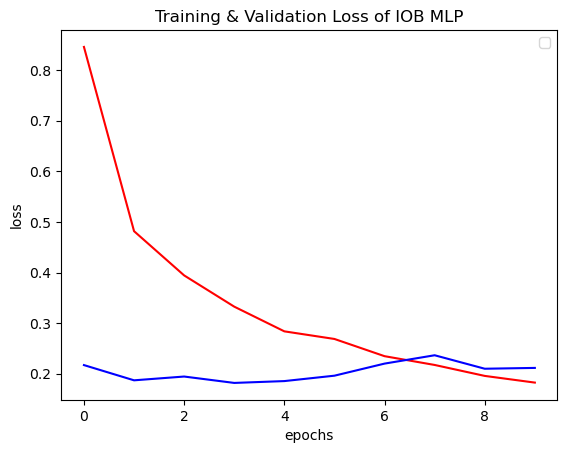

In [18]:
plt.figure()
plt.plot(loss_all_epochs, 'red')
plt.plot(val_loss_all_epochs, 'blue')
plt.xlabel('epochs'), plt.ylabel('loss')
plt.title('Training & Validation Loss of IOB MLP')
plt.legend()
#plt.savefig('/Users/josephkeenan/Desktop/UE901/DNN/Labs/lab3/sig_loss.png')
plt.show()

In [19]:
# TO DO: Evaluate the model on the test set:
# - Instanciate an MLP newtork and load the trained parameters
# - Apply the evaluation function using the test dataloader
# - Print the test accuracy
model_trained = MLPClassif(input_size, hidden_size, num_classes, nn.ReLU())

model_trained.load_state_dict(torch.load('models/model_MLP_classif.pt'))

accuracy, B_acc, I_acc, O_acc, test_loss, total_preds, total_labels = eval_mlp_classifier(model_trained, test_dataloader, loss_fn)
print(f'Test Accuracy: {accuracy:.3f}%')
print(f'B Accuracy: {B_acc:.3f}%')
print(f'I Accuracy: {I_acc:.3f}%')
print(f'O Accuracy: {O_acc:.3f}%\n')


# Converting predictions and labels to lists so we can run them through sklearn precision_recall_fscore_support
total_preds2 = []
total_labels2 = []

for batch in total_preds:
    for item in batch:
        item = item.tolist()
        total_preds2.append(int(item.index(max(item))))
        
for batch in total_labels:
    for item in batch:
        total_labels2.append(int(item))

        
# Precision, Recall, and F1 Score for MLP Classifier
precision, recall, f1, support = precision_recall_fscore_support(total_labels2, total_preds2)

for index, (b, i, o) in enumerate(zip(precision, recall, f1)):
    if index == 0:
        print('Precision')
    elif index == 1:
        print('Recall')
    else:
        print('F1-score')
    print(f'B: {b}')
    print(f'I: {i}')
    print(f'O: {o}\n')

Test Accuracy: 87.554%
B Accuracy: 86.882%
I Accuracy: 90.162%
O Accuracy: 85.605%

Precision
B: 0.854122621564482
I: 0.8688172043010752
O: 0.861407249466951

Recall
B: 0.9035752979414952
I: 0.9016216216216216
O: 0.9025974025974026

F1-score
B: 0.8693244739756367
I: 0.8560523446019629
O: 0.8626373626373626



## Baseline Random Forest Classifier

In [20]:
train_data, train_labels = train_split
train_data = [np.array(x) for x in train_data]
train_labels = [np.array(x) for x in train_labels]

test_data, test_labels = test_split
test_data = [np.array(x) for x in test_data]
test_labels = [np.array(x) for x in test_labels]

In [21]:
crf_classifier = RandomForestClassifier()
crf_classifier.fit(train_data, train_labels)

RandomForestClassifier()

In [22]:
crf_scores = crf_classifier.score(test_data, test_labels)
preds = crf_classifier.predict(test_data)
precision, recall, f1, support = precision_recall_fscore_support(test_labels, preds)

print(f'Overall Accuracy: {crf_scores}\n')
for index, (b, i, o) in enumerate(zip(precision, recall, f1)):
    if index == 0:
        print('Precision')
    elif index == 1:
        print('Recall')
    else:
        print('F1-score')
    print(f'B: {b}')
    print(f'I: {i}')
    print(f'O: {o}\n')

Overall Accuracy: 0.8773448773448773

Precision
B: 0.7555555555555555
I: 0.5182926829268293
O: 0.6148282097649187

Recall
B: 0.8015873015873016
I: 0.7809278350515464
O: 0.7911227154046997

F1-score
B: 0.9031811894882434
I: 0.9528210116731517
O: 0.9273372781065088

